In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
from QuantLib import *
import time
import matplotlib.pyplot as plt

In [8]:
# Define your stock symbol and option details
stock_symbol = "AAPL"
expiry_date = "2023-12-31"
strike_price = 150

# Define the number of Monte Carlo simulations
num_simulations = 1000

# Define risk-free rate and volatility (you should get these from your data source)
risk_free_rate = 0.03
annual_volatility = 0.2

# Retrieve historical stock data
stock_data = yf.download(stock_symbol, start="2023-01-01", end="2023-12-31")

# Calculate daily returns
stock_data['Returns'] = stock_data['Adj Close'].pct_change()

# Calculate daily drift and volatility
daily_drift = (risk_free_rate - (annual_volatility ** 2) / 2) / 252
daily_volatility = annual_volatility / np.sqrt(252)

print(daily_drift)
print(daily_volatility)

[*********************100%***********************]  1 of 1 completed


In [12]:
# Create a function to perform Monte Carlo simulation for option pricing
def monte_carlo_option_price(stock_price, num_simulations):
    option_price_sum = 0

    for _ in range(num_simulations):
        daily_returns = np.random.normal(daily_drift, daily_volatility, 252)
        final_stock_price = stock_price * np.exp(np.sum(daily_returns))
        
        # Calculate option payoff at expiry (European call option)
        option_payoff = max(final_stock_price - strike_price, 0)
        
        # Discount option payoff to present value
        discounted_option_payoff = option_payoff / ((1 + risk_free_rate) ** 252)
        
        option_price_sum += discounted_option_payoff
    
    return option_price_sum / num_simulations

# Calculate the option price using Monte Carlo simulation
initial_stock_price = stock_data['Adj Close'][-1]
option_price = monte_carlo_option_price(initial_stock_price, num_simulations)

print(f"Monte Carlo Option Price: {option_price:.2f}")

Monte Carlo Option Price: 0.02


In [13]:
# Create a function to backtest the option strategy
def backtest_option_strategy(data,initial_capital,contracts_per_trade):
    option_prices = []
    portfolio_values = []
    cumulative_returns = []
    pnl = []  # To store daily profit and loss

    start_time = time.time()

    for i, row in data.iterrows():
        # Calculate option price using Monte Carlo simulation
        option_price = monte_carlo_option_price(row['Adj Close'], num_simulations)
        option_prices.append(option_price)

        # Calculate portfolio value
        portfolio_value = option_price * contracts_per_trade * 100  # Contracts * Lots * Shares per Contract
        portfolio_values.append(portfolio_value)

        # Calculate cumulative returns
        cumulative_return = (np.sum(portfolio_values) + initial_capital) / initial_capital
        cumulative_returns.append(cumulative_return)

        # Calculate daily profit and loss
        daily_pnl = portfolio_value - initial_capital
        pnl.append(daily_pnl)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken for backtesting: {elapsed_time:.2f} seconds")

    data['Option Price'] = option_prices
    data['Portfolio Value'] = portfolio_values
    data['Cumulative Return'] = cumulative_returns
    data['PnL'] = pnl  # Add P&L column to the data

    return data

In [14]:
# Define your initial capital and the number of contracts (lots) you want to trade per signal
initial_capital = 100
contracts_per_trade = 1  # You can adjust this as needed
total_price=0
for  total_price in range(initial_capital):
        total_price=contracts_per_trade*option_price
        contracts_per_trade+=1

# Backtest the option strategy using historical stock data
backtested_data = backtest_option_strategy(stock_data,initial_capital,contracts_per_trade)

# Print the final portfolio value
final_portfolio_value = backtested_data['Cumulative Return']

Time taken for backtesting: 2.73 seconds


In [16]:
print(backtested_data)

print(contracts_per_trade)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  130.279999  130.899994  124.169998  125.070000  124.538658   
2023-01-04  126.889999  128.660004  125.080002  126.360001  125.823189   
2023-01-05  127.129997  127.769997  124.760002  125.019997  124.488869   
2023-01-06  126.010002  130.289993  124.889999  129.619995  129.069336   
2023-01-09  130.470001  133.410004  129.889999  130.149994  129.597076   
...                ...         ...         ...         ...         ...   
2023-08-30  184.940002  187.850006  184.740005  187.649994  187.649994   
2023-08-31  187.839996  189.119995  187.479996  187.869995  187.869995   
2023-09-01  189.490005  189.919998  188.279999  189.460007  189.460007   
2023-09-05  188.279999  189.979996  187.610001  189.699997  189.699997   
2023-09-06  188.399994  188.735001  183.529999  184.184998  184.184998   

               Volume   Returns  Opti

In [17]:
# Print the final portfolio value
final_portfolio_value = backtested_data['Cumulative Return'].iloc[-1] * initial_capital
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")

Final Portfolio Value: $28926.89


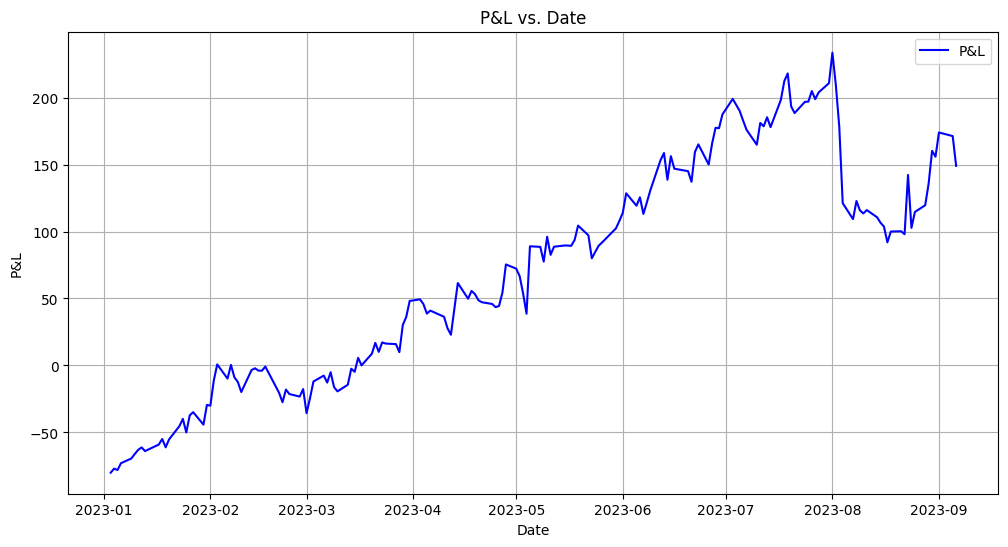

In [18]:
# Plot the Profit and Loss (P&L) with respect to the date
plt.figure(figsize=(12, 6))
plt.plot(backtested_data.index, backtested_data['PnL'], label='P&L', color='blue')
plt.xlabel('Date')
plt.ylabel('P&L')
plt.title('P&L vs. Date')
plt.grid(True)
plt.legend()
plt.show()

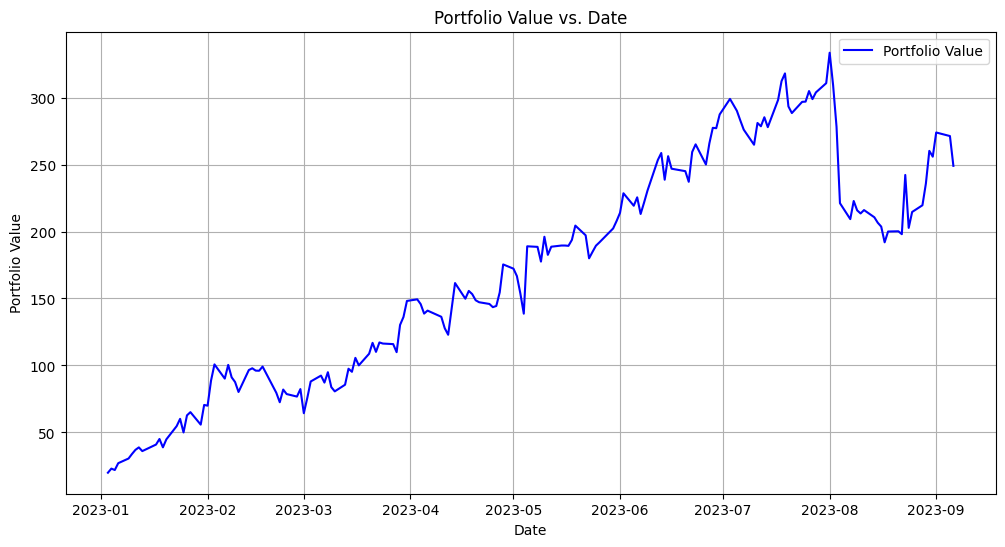

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(backtested_data.index, backtested_data['Portfolio Value'], label='Portfolio Value', color='blue')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value vs. Date')
plt.grid(True)
plt.legend()
plt.show()